In [9]:
import pandas as pd
import numpy as np
import string
import re
import nltk
# nltk.download()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.naive_bayes import GaussianNB

El presente proyecto consiste en aplicar la metodología propuesta en el artículo Manochandar et al. "Scaling feature selection method for enhancing the classification performance of Support Vector Machines in text mining". [ver paper aquí](https://github.com/JuanOlmos/Aprendizaje_Automatico/blob/main/SVM_Tweets/Manochandar_scalingFeatureSelection.pdf)

El objetivo principal consiste en selecionar el número mínimo de características para clasificar reseñas (comentarios) de una manera efectiva. Para esto, se utilizarán los métodos tf-idf y Glasgow  para la selección de características en la minería de opiniones.

El conjunto de datos elegido consiste en tweet de ususarios de Amazon que adquirieron productos y han dejado comentarios al respecto. Estos comentarios fueron etiquetados como "Negativos" y "Positivos". En total se tiene un conjunto de datos balanceado.

A continuación leeremos los tweets y mostraremos su respectiva clase 0 O 1, correspondiendo a "Negativos" o "Positivos" respectivamente.

<!-- Realizar las siguientes tareas:

1.Elegir 100 tuist y clasificarlos de manera subjetiva como positivo o negativo
2.Aplicar un análisis descriptivos sobre los 100 tuist.
3.Presentar una clasificación mediante un clasificador Naive Bayes
Describir en que consiste las representaciones gráficas para reducir el tamaño del conjunto de características.

 Discutir la forma cómo la precisión de las expresiones se mejoran a través de la técnica de máquina de vectores de soporte. -->

In [10]:
df = pd.read_csv("../data/svm_tweets/twitter_training.csv", header = None)
df = df[df[1] == "Amazon"]
df.columns = ["c0","c1","class","text"] 
# df = df.drop_duplicates(inplace = True)
n_positives = np.sum(df["class"] == "Positive")
n_negatives = np.sum(df["class"] == "Negative")
print(f"There is {n_positives} Positives AND {n_negatives} Negatives")
df = df[(df["class"] == "Positive") | (df["class"] == "Negative")]
size = 300        # sample size
replace = True  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
df = df.groupby('class', as_index=False).apply(fn).reset_index()
df = df[["text","class"]]
df["text"] = df["text"].astype("str")
df["class"] = df["class"].replace(["Negative","Positive"],[0,1])
df

There is 312 Positives AND 576 Negatives


,text,class
0,Hey @Bezos @Amazon @Instacart what the actual ...,0
1,<unk> wtf.,0
2,There's a Kobe jersey on Amazon for $7K. Y'all...,0
3,"Seriously at this point, don't get me days or ...",0
4,Really Amazon. Fuck off or no goddamn way...,0
...,...,...
595,"You tend to expect better online service, like...",1
596,Thank God they're ready to work,1
597,<unk> amazon package got me at omg im so happy...,1
598,It is not the first time that the EU Commissio...,1


Siguiendo la metodología del artículo, realizamos ahora un proceso de pre-procesamiento de los mensajes:

* eliminando caracteres y puntuaciones, 
* tokenizando (separar en unidades mas pequeñas), 
* removiendo "stopwords" (depurar palabras no tan importantes y con gran densidad en las frases, como "the, an, a,...")
* Haciendo "stemming".

In [11]:
#Cleaning Text
def clean_text(text):
    ps = nltk.PorterStemmer()
    stopword = nltk.corpus.stopwords.words('english')
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text

A continuación una función que retorna las features mas probables y su crf. 

In [12]:
def get_probs(df, op = "1"):    
    #Appliyng Countvectorizer
    if op == "1":
        countVectorizer = CountVectorizer(analyzer=clean_text) 
    elif op == "2":
        countVectorizer = TfidfVectorizer(analyzer=clean_text) 
    
    countVector = countVectorizer.fit_transform(df['text'])
    # print("{} Number of reviews has {} words".format(countVector.shape[0], countVector.shape[1]))
    #print(countVectorizer.get_feature_names())
    count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())
    display(count_vect_df)
    #calculating probs    
    X = count_vect_df.values[:,:]
    print(f'X shape: {X.shape}')
    probs = np.mean(X, axis = 0) 
    probs = pd.DataFrame({"Probs":probs})
    probs = probs.sort_values(by = "Probs", ascending=False)
    probs["probs2"] = probs["Probs"] / probs["Probs"].sum()
    probs["crf"] = probs["probs2"].cumsum()
    return count_vect_df, probs


Con el crf calculado, se aplica el **método gráfico** que indica el articulo, el cual consiste en analizar la curva de las probabilidades acumuladas. Especificamente, se analiza la recta tangente y se toma como el número optimo de características cuando la curva empiece a tender a una posicion horizontal. En este caso decidimos tomar 1000.

/Users/juanolmos/opt/anaconda3/envs/dl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,,absolut,access,acknowledg,acquisit,across,action,activ,actual,ad,...,yesterday,yet,ynabest,ynasv,yo,youll,young,youth,youtub,youtubelkpoeeulxm
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
596,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
597,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
598,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/Users/juanolmos/opt/anaconda3/envs/dl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


X shape: (600, 1308)


,,absolut,access,acknowledg,acquisit,across,action,activ,actual,ad,...,yesterday,yet,ynabest,ynasv,yo,youll,young,youth,youtub,youtubelkpoeeulxm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.167274,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


X shape: (600, 1308)


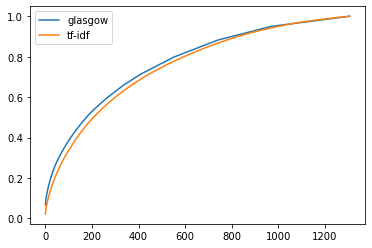

In [13]:
mop1, prosop1 = get_probs(df = df, op = "1")
mop2, prosop2 = get_probs(df = df, op = "2")
xx = np.arange(len(prosop1.crf))
plt.plot(xx,prosop1.crf, label = "glasgow")
plt.plot(xx,prosop2.crf, label = "tf-idf")
plt.legend()

Una vez hecho el método gráfico, analizaremos las métricas de clasificación utilizando Naive Bayes y SVM como indica el articulo

In [66]:
def calculate_metrics(df,mop):
    X, y = mop.values, df["class"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for name_clf, clf in zip(["NAIVE BAYES","SVM"],[GaussianNB(),SVC()]):        
        clf.fit(X, y)
        y_pred = clf.predict(X_test)
        """ 
        -----   Metrics  -----
        """   
        acc = accuracy_score(y_test, y_pred)
        prf = precision_recall_fscore_support(y_test, y_pred,zero_division=0.0)
        pre, spe, sen, f1s = prf[0][1], prf[1][0], prf[1][1], prf[2][1]

        metrics_df = pd.DataFrame({'Recall': [sen],                    
                            'Precision': [pre],
                            'Accuracy': [acc],
                            'F1-Score': [f1s]})
        print(f"Results using: {name_clf}'")            
        display(metrics_df)
    


Utilizando la formula de **Glasgow** 

In [67]:
calculate_metrics(df = df, mop = mop1)

Results using: NAIVE BAYES'


,Recall,Precision,Accuracy,F1-Score
0,1.0,0.95082,0.975,0.97479


Results using: SVM'


,Recall,Precision,Accuracy,F1-Score
0,1.0,0.935484,0.966667,0.966667


Utilizando **tf-idf**

In [68]:
calculate_metrics(df = df, mop = mop2)

Results using: NAIVE BAYES'


,Recall,Precision,Accuracy,F1-Score
0,1.0,0.95082,0.975,0.97479


Results using: SVM'


,Recall,Precision,Accuracy,F1-Score
0,1.0,0.966667,0.983333,0.983051
